# Project: Advanced Lane Finding

In this project, the goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. 

## Camera calibration

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
#%matplotlib qt
%matplotlib inline

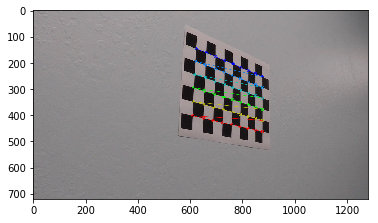

In [2]:
# prepare object points
nx = 9 #the number of inside corners in x
ny = 6 #the number of inside corners in y

# Read in an image
images = glob.glob('camera_cal/calibration*.jpg')

def cal_camera(images, nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            plt.imshow(img)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)
    return mtx, dist

mtx, dist = cal_camera(images, nx, ny)

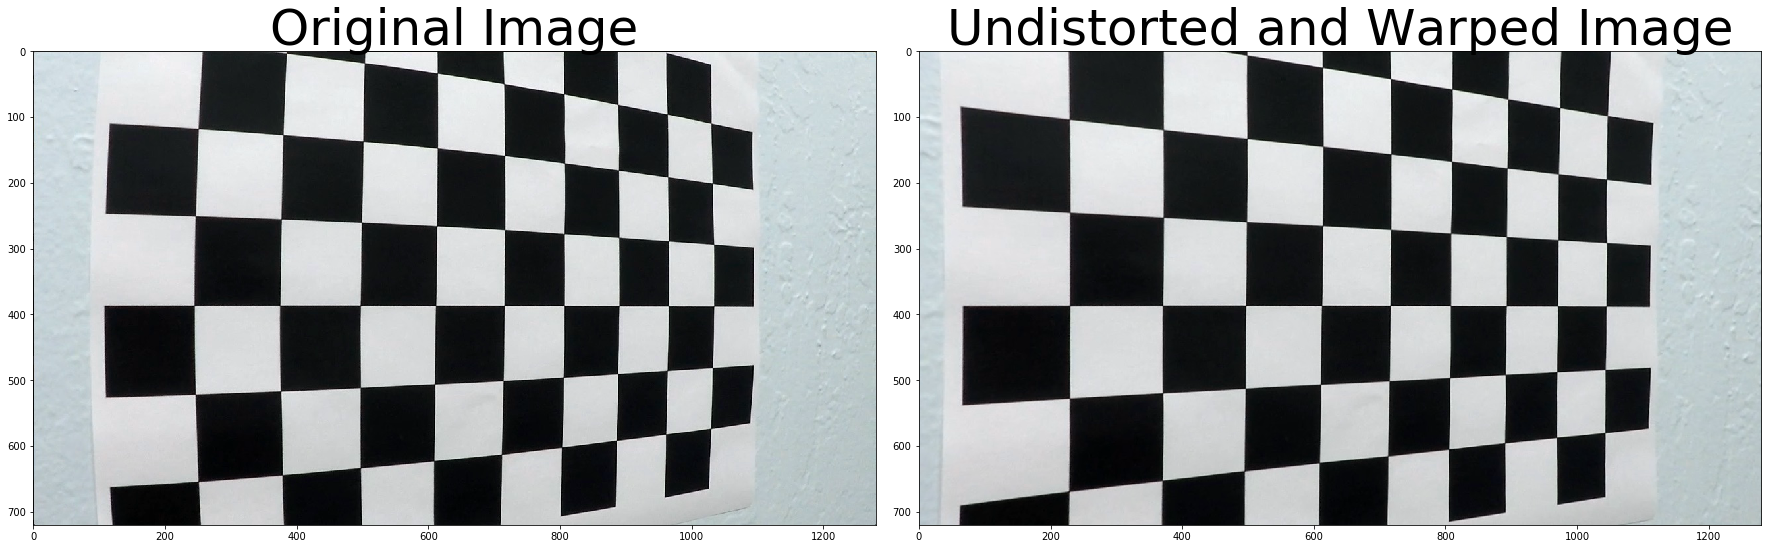

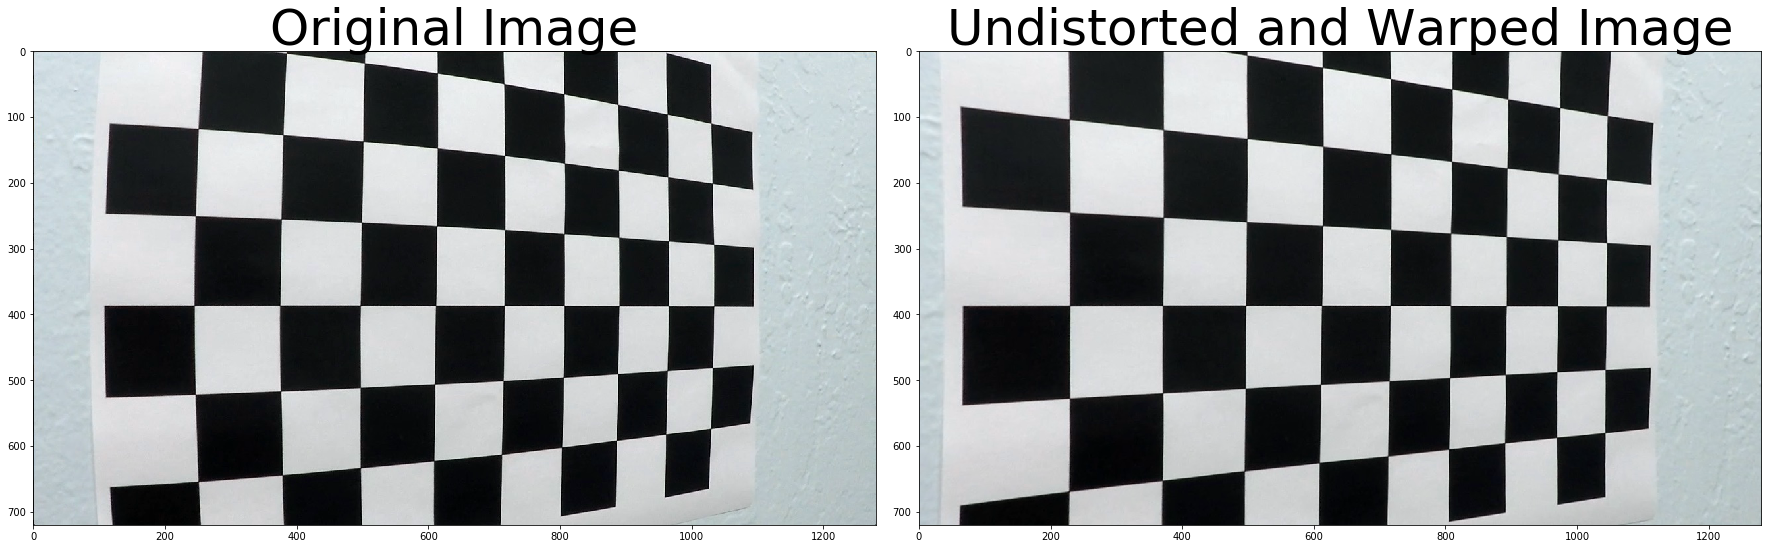

In [3]:
def cal_undistort(img, mtx, dist):
    # Use cv2.undistort()
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def plot_2_images(img1,img2,tit1,tit2):
    '''
    Visualize undistortion
    ''' 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(tit1, fontsize=50)
    if img2.shape[-1] != 3:
        ax2.imshow(img2, cmap='gray')
    else:
        ax2.imshow(img2)
    ax2.set_title(tit2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

img = cv2.imread('camera_cal/calibration5.jpg')
undist = cal_undistort(img, mtx, dist)
# Visualize undistortion
plot_2_images(img,undist,'Original Image','Undistorted and Warped Image')

img = cv2.imread('camera_cal/calibration5.jpg')
undist = cal_undistort(img, mtx, dist)
# Visualize undistortion
plot_2_images(img,undist,'Original Image','Undistorted and Warped Image')

## Distortion correction

Apply a distortion correction to raw images.

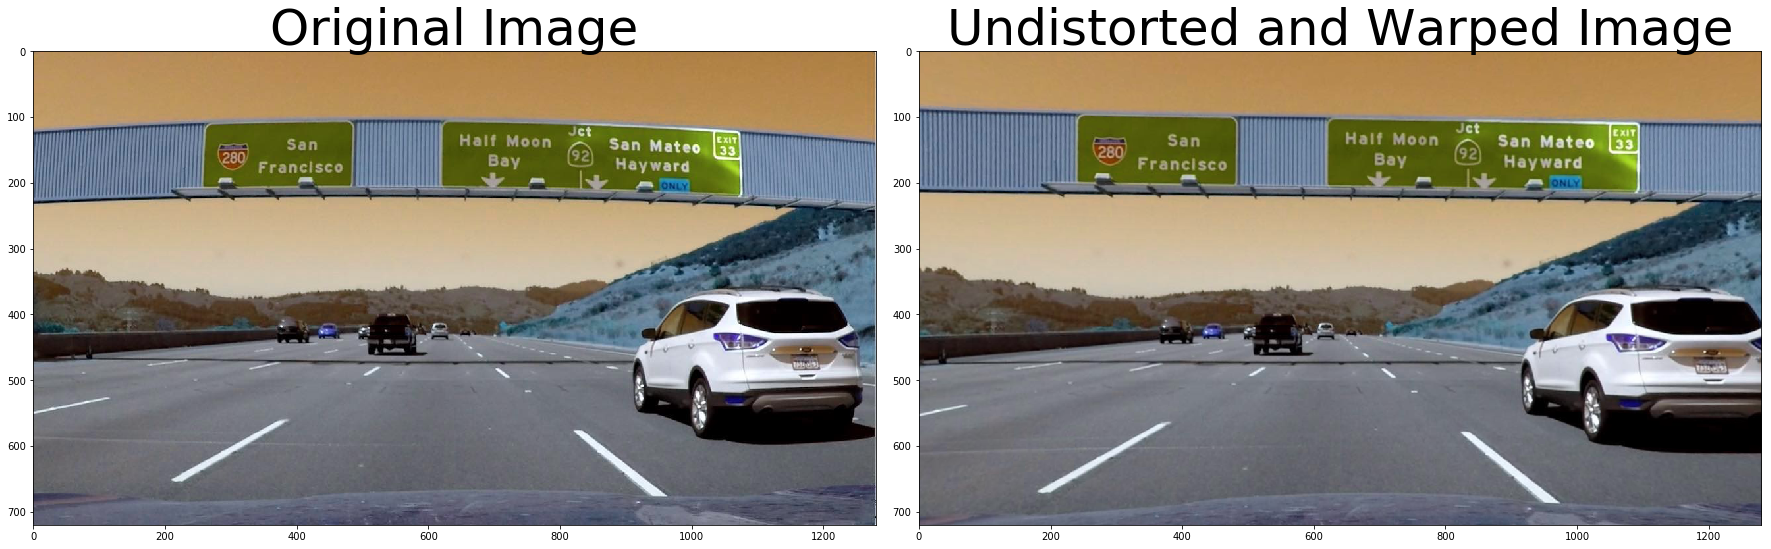

In [4]:
img = cv2.imread('test_images/signs_vehicles_xygrad.png')
undist = cal_undistort(img, mtx, dist)
# Visualize undistortion
plot_2_images(img,undist,'Original Image','Undistorted and Warped Image')

## Color/gradient threshold

Use color transforms, gradients, etc., to create a thresholded binary image.

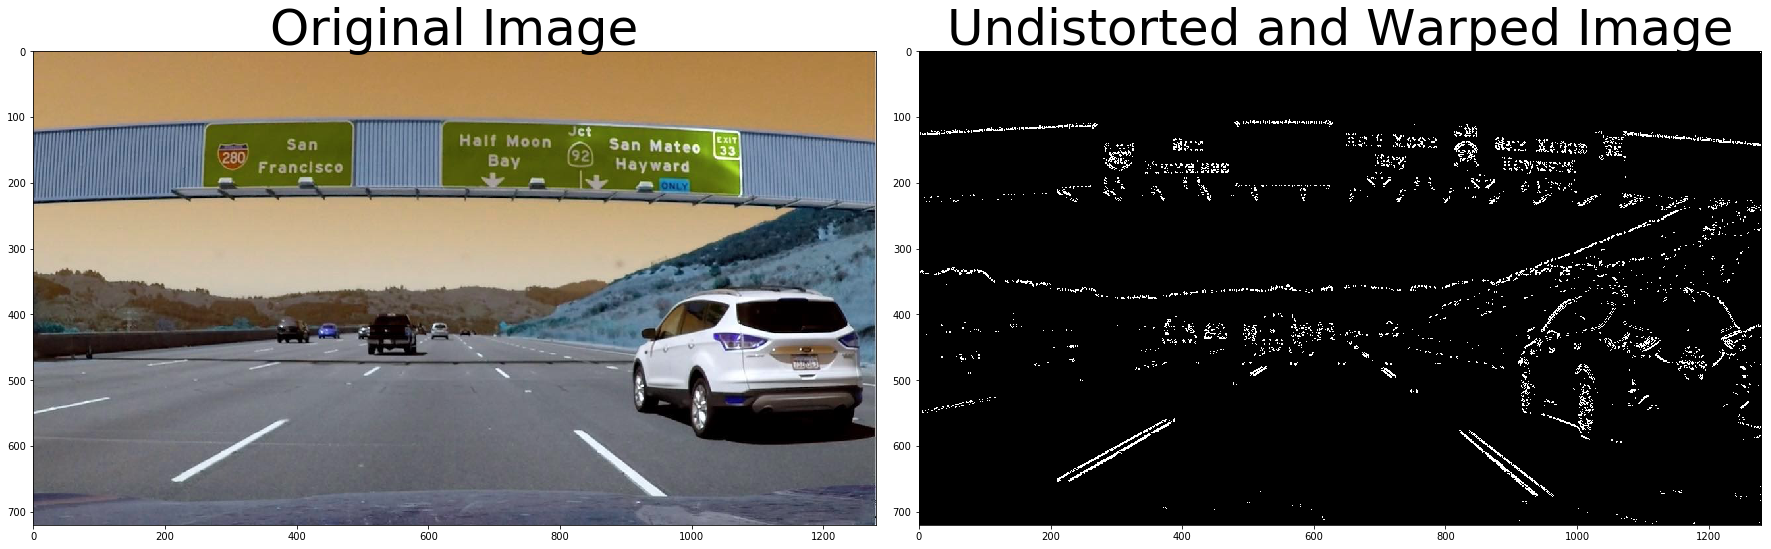

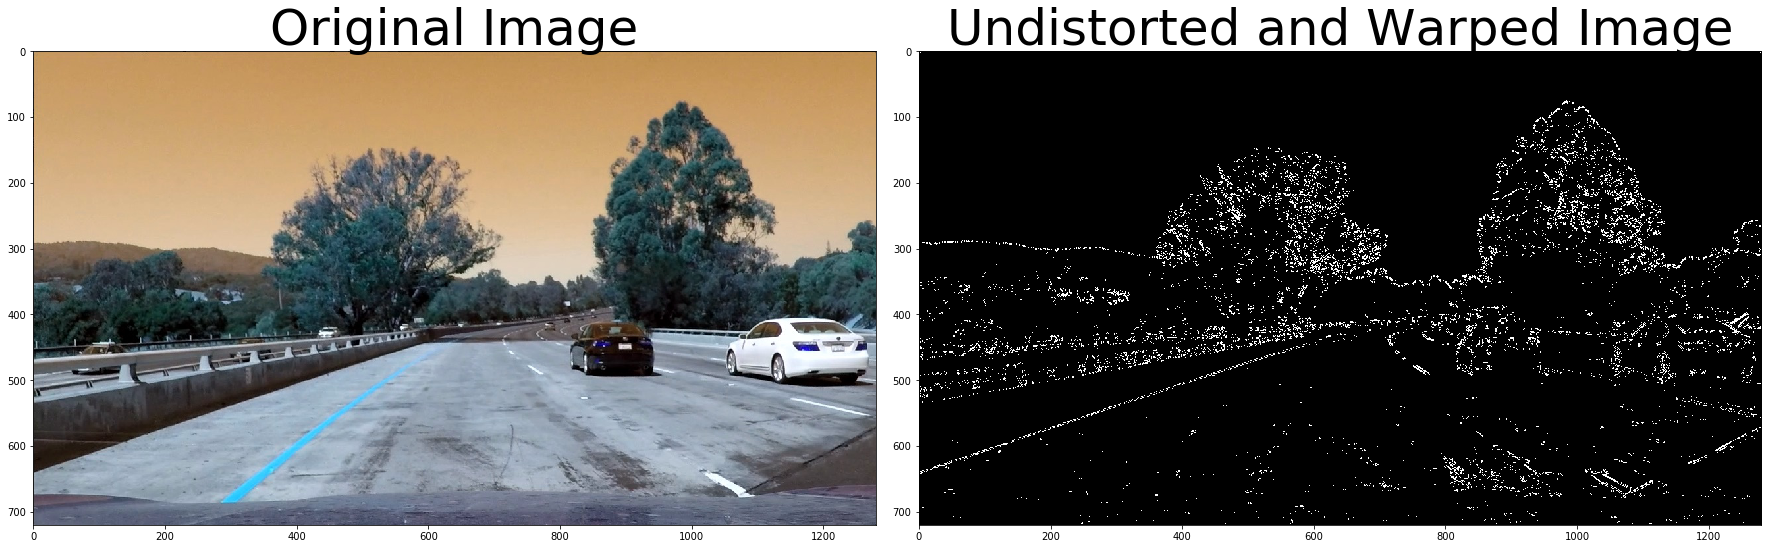

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
def comb_thresh(img):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

result = comb_thresh(img)
plot_2_images(img,result,'Original Image','Undistorted and Warped Image')

img2 = cv2.imread('test_images/test1.jpg')
result = comb_thresh(img2)
plot_2_images(img2,result,'Original Image','Undistorted and Warped Image')

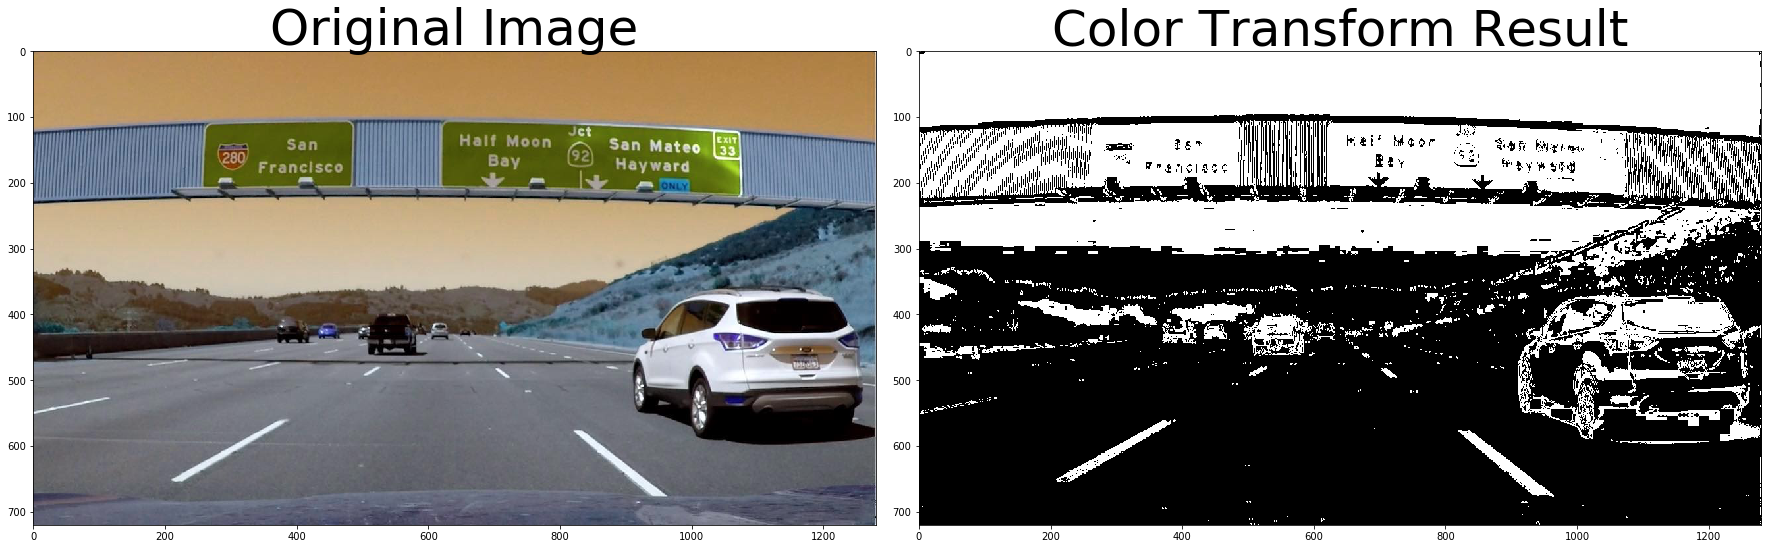

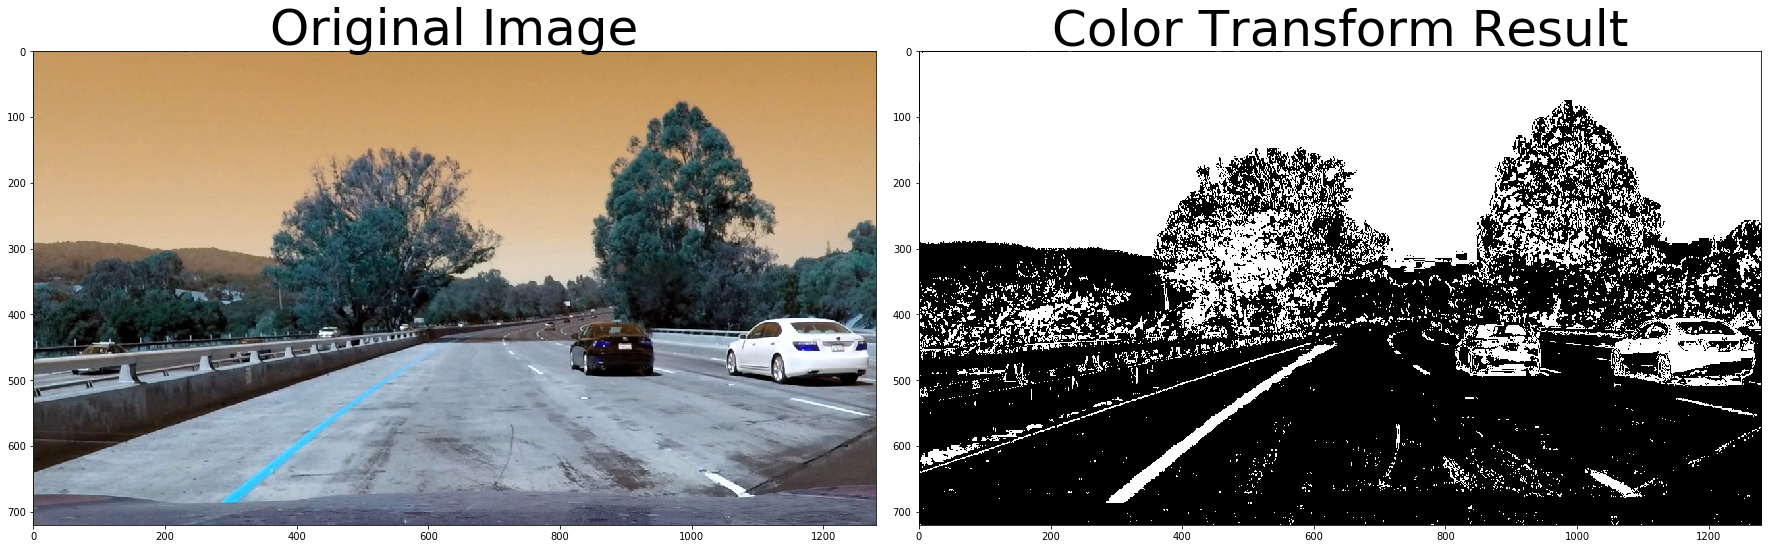

In [6]:
def comb_color_thresh(img, s_thresh=(90, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    
result = comb_color_thresh(img)
plot_2_images(img,result,'Original Image','Color Transform Result')

result = comb_color_thresh(img2)
plot_2_images(img2,result,'Original Image','Color Transform Result')

## Perspective transform

Apply a perspective transform to rectify binary image ("birds-eye view").

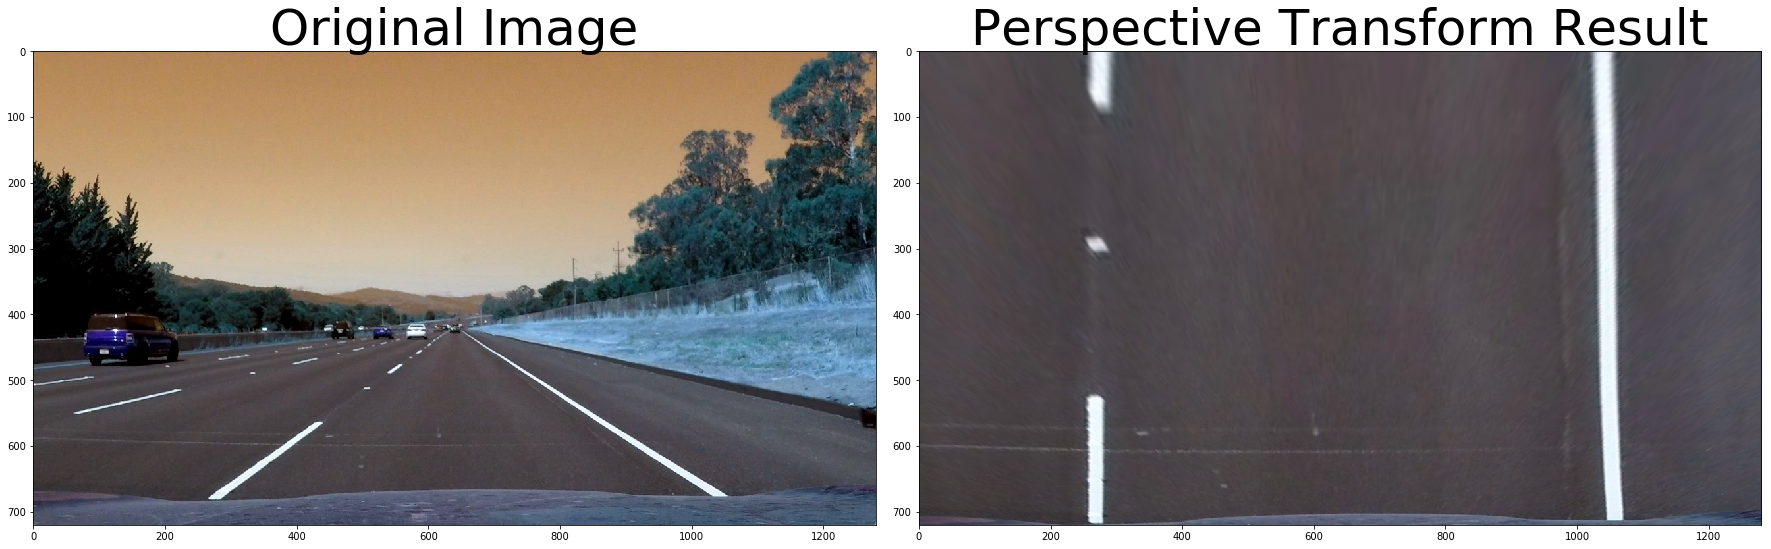

In [7]:
def perspective_transform(img):
    HEIGHT, WIDTH = img.shape[:2]
    offset = 40
    src = np.array([[WIDTH*0.375, HEIGHT*0.67], [WIDTH*0.625, HEIGHT*0.67], [0, HEIGHT*0.95], [WIDTH, HEIGHT*0.95]], np.float32)
    dst = np.array([[0, 0], [WIDTH, 0], [0, HEIGHT], [WIDTH, HEIGHT]], np.float32)    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (WIDTH, HEIGHT), flags=cv2.INTER_LINEAR)
    return warped, Minv
img3 = cv2.imread('test_images\straight_lines2.jpg')
result, Minv = perspective_transform(img3)
# print (undist.shape)
plot_2_images(img3,result,'Original Image','Perspective Transform Result')

(720, 1280)


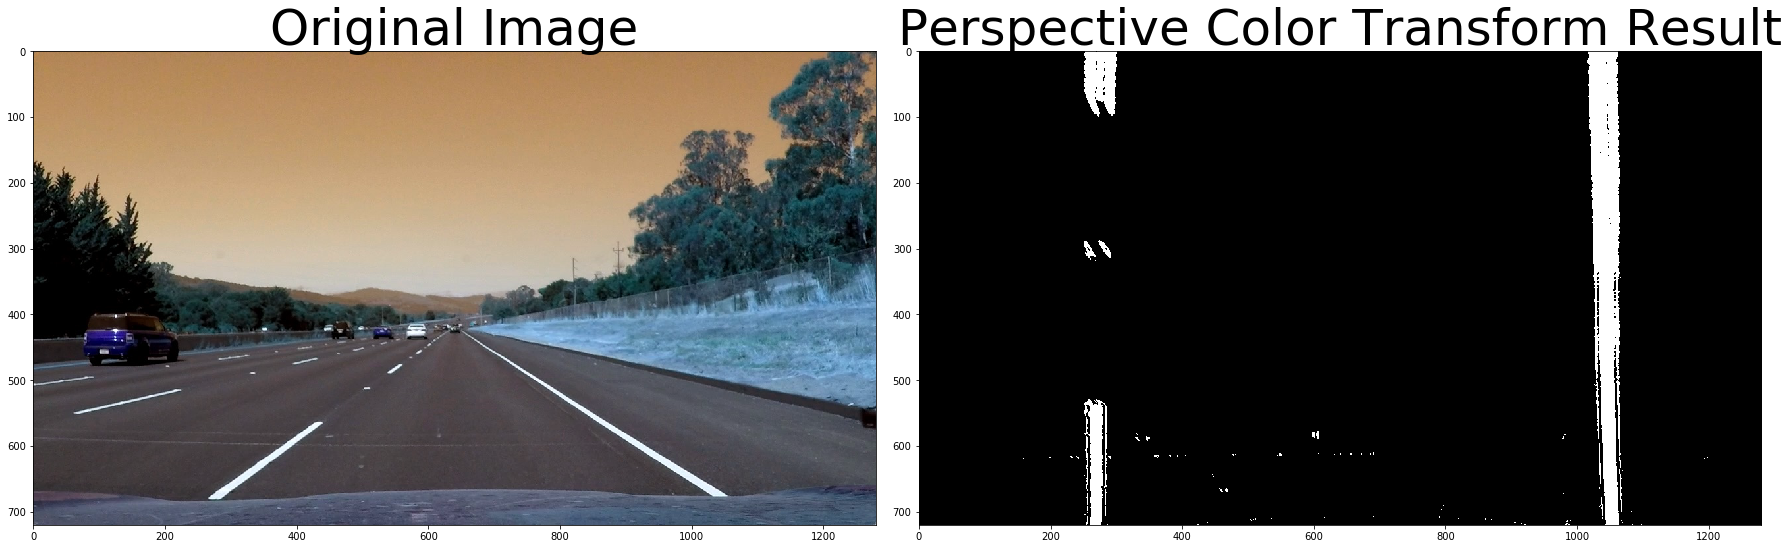

In [8]:
def perspective_color_thresh(img):
    img = np.copy(img)
    undist = cal_undistort(img, mtx, dist)
    warped, Minv = perspective_transform(undist)
    combined_binary = comb_color_thresh(warped)
    return combined_binary, Minv

perd,Minv = perspective_color_thresh(img3)
print (perd.shape)
plot_2_images(img3,perd,'Original Image','Perspective Color Transform Result')    

## Detect lane lines

Detect lane pixels and fit to find the lane boundary.

C:\Users\tinghsiangc\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


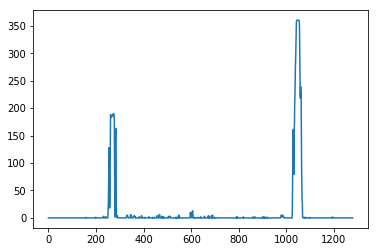

C:\Users\tinghsiangc\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


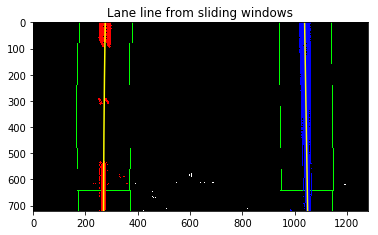

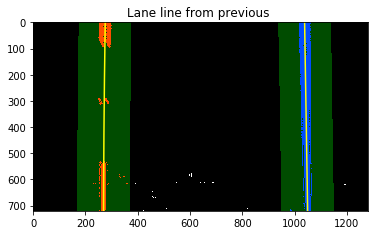

In [9]:
def draw_hist(img):
    img = np.copy(img)
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    return histogram

def sliding_windows(binary_warped, nwindows = 9, margin = 100, minpix = 50, plot = False):
    '''
    Sliding the windows to find the lane lines
    '''
    binary_warped = np.copy(binary_warped)
    # Already created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if plot:
        #Visualization
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.title('Lane line from sliding windows')
        plt.show()
    return  left_fit, right_fit

def fit_next_frame(binary_warped, left_fit, right_fit, margin = 100, plot = False):
    '''
    Using the lane line from the previous to find the next one
    '''    
    binary_warped = np.copy(binary_warped)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if plot:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.title('Lane line from previous ')
    return left_fit, right_fit
hist = draw_hist(perd)
plt.plot(hist)
plt.show()
left_fit, right_fit = sliding_windows(perd, plot = True)   
left_fit, right_fit = fit_next_frame(perd, left_fit, right_fit, plot = True)

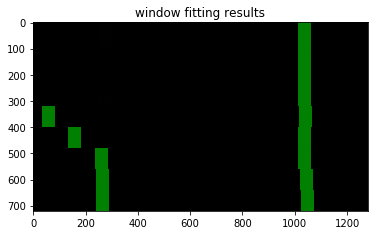

In [10]:
# Read in a thresholded image
warped = perd
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*warped.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*warped.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

## Determine the lane curvature

Determine the curvature of the lane and vehicle position with respect to center.

In [11]:
def fake_data():
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Plot up the fake data
    mark_size = 3
    plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
    plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    
    return left_fit, right_fit

def curvature(left_fit, right_fit):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def curvature_real_world(left_fit, right_fit):
    '''
    Calculate curvature for left and right lane line and transfer to real world distance
    '''
    #using 20 instead of 30 here since the perspective transform is 1.5x much longer than original image
    ym_per_pix = 20/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Generate x and y values from second order polynomial
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    y_eval = np.max(ploty)
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad
#left_fit, right_fit = fake_data()
left_curverad, right_curverad =  curvature(left_fit, right_fit)
print(left_curverad, right_curverad)
left_curverad, right_curverad =  curvature_real_world(left_fit, right_fit)
# radius of curvature in meters
print(left_curverad, 'm', right_curverad, 'm')

53707.6420929 564933.478529
7840.15161204 m 82434.9094659 m


## Drawing

Warp the detected lane boundaries back onto the original image.

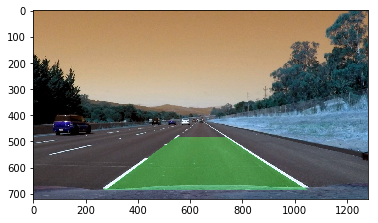

In [12]:
def draw_lines(img, warped, left_fit, right_fit, Minv):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result
result = draw_lines(img3, perd, left_fit, right_fit, Minv)
plt.imshow(result)

 # Tracking

To keep track of things like where the last several detections of the lane lines were and what the curvature was, to properly treat new detections. 
Define a Line() class to keep track of all the interesting parameters you measure from frame to frame.

In [47]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # N of previous data
        self.n = 10   
        #polynomial coefficients averaged over the last n iterations
        self.weight_fit = None 
        #polynomial coefficients for the best fit
        self.best_fit = None        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
    def set_current_fit(self, fit):
        self.current_fit = fit
    def get_current_fit(self):
        return self.current_fit          
    def get_best_fit(self):
        return self.best_fit       
    def get_fit(self):
        if self.best_fit == None:
            self.best_fit = self.current_fit
        else:
            self.weight_fit = (self.best_fit * (self.n - 1) + self.current_fit)/self.n
            if is_parallel(self.best_fit, self.weight_fit):
                self.best_fit = self.weight_fit
        return self.best_fit

# Visualization

Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [48]:
# Initial global parameter
left = Line()
right = Line()

True

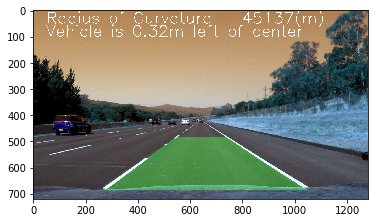

In [51]:
img = cv2.imread('test_images/straight_lines2.jpg')
#img = cv2.imread('output_images/project_imgs/org_618.jpg')
def line_checker(fit1, fit2):
    '''
    Check does two new lines detections makes sense
    '''
    return is_parallel(fit1,fit2) and is_valid_dist(fit1, fit2)

def is_valid_dist(fit1, fit2, thresh=(500, 900)):
    '''
    Checking that they are separated by approximately the right distance horizontally
    '''
    dist = np.abs(get_x_position(fit1,719) - get_x_position(fit2,719))
    return thresh[0] < dist < thresh[1]

def is_continuous(line):
    for a, b in zip(line.get_current_fit()[:2],line.get_best_fit()[:2]):
        if np.absolute(a - b) > 0.5:
            return False
    return True    

def is_parallel(fit1, fit2, thresh=(0.0003, 0.1)):
    '''
    Checking that they are roughly parallel
    '''
    for a, b, th in zip(fit1[:2],fit2[:2], thresh):
        if np.absolute(a - b) > th:
            return False
    return True

def get_x_position(fit, y):
    '''
    Get x position from the polyfit
    '''
    return fit[0]*y**2 + fit[1]*y + fit[2]

def get_direction(left_fit, right_fit, img):
    '''
    Get position of center location
    '''
    xm_per_pix = 3.7/700
    ploty = img.shape[0]
    left_pos = get_x_position(left_fit, ploty)
    right_pos = get_x_position(right_fit, ploty)
    offest = (left_pos + right_pos)/2 - img.shape[0]
    direction = "left" if offest < 0 else "right"
    return abs(offest*xm_per_pix), direction

def pipeline(img):
    global left, right
    img = np.copy(img)
    # Transform undistort pic to "birds-eye view" with thresholded binary image
    warped, Minv = perspective_color_thresh(img)
    
    # Find the fit for the current image either sliding windows or use previous data as base
    if not left.detected and not right.detected:
        left_current_fit, right_current_fit = sliding_windows(warped)
        left.detected = right.detected = True
    else: 
        left_current_fit, right_current_fit = fit_next_frame(warped, left.get_best_fit(), right.get_best_fit())
        
    # Sanity Check for current fit, if current fit failed on Sanity Check, use the previous fit.     
    left.set_current_fit(left_current_fit)
    right.set_current_fit(right_current_fit)
    if not line_checker(left.get_current_fit(), right.get_current_fit()):
        left_fit, right_fit = left.get_best_fit(), right.get_best_fit()
        left.detected = right.detected = False
    else:    
        left_fit, right_fit = left.get_fit(), right.get_fit()

    # Calculate curvature for the line and offset for the camera    
    curves = curvature_real_world(left_fit, right_fit)
    curvature = (curves[0] + curves[1])/2
    offest, direction = get_direction(left_fit, right_fit, img) 
    result = draw_lines(img, warped, left_fit, right_fit, Minv)
    
    # Add curvature and offset info to the image
    cv2.putText(result, 'Vehicle is %.2fm %s of center' % (offest, direction), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2,
                (255, 255, 255), 2)    
    cv2.putText(result, 'Radius of Curvature = %d(m)' % curvature, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    #left.best_fit = left_fit
    #right.best_fit = right_fit
    #print (left_fit, right_fit)
    return result
result = pipeline(img)
plt.imshow(result)
cv2.imwrite('output_images/result.jpg',result)

In [52]:
# Initial global parameter
left = Line()
right = Line()

In [53]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'project_output.mp4'
clip2 = VideoFileClip('project_video.mp4')
project_clip = clip2.fl_image(pipeline)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4





  0%|                                                 | 0/1261 [00:00<?, ?it/s]


  0%|                                         | 1/1261 [00:00<03:09,  6.67it/s]


  0%|                                         | 2/1261 [00:00<03:08,  6.67it/s]


  0%|                                         | 3/1261 [00:00<03:08,  6.67it/s]


  0%|▏                                        | 4/1261 [00:00<03:12,  6.54it/s]


  0%|▏                                        | 5/1261 [00:00<03:07,  6.71it/s]


  0%|▏                                        | 6/1261 [00:00<03:18,  6.31it/s]


  1%|▏                                        | 7/1261 [00:01<03:22,  6.18it/s]


  1%|▎                                        | 8/1261 [00:01<03:25,  6.09it/s]


  1%|▎                                        | 9/1261 [00:01<03:24,  6.13it/s]


  1%|▎                                       | 10/1261 [00:01<03:19,  6.28it/s]


  1%|▎                                       | 11/1261 [00:01<03:15,  6.39it/s]


  1%|▍       

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 3min 24s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [ ]:
# Initial global parameter
left = Line()
right = Line()

In [ ]:
challenge_output = 'challenge_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
challenge_clip = clip2.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# Debug

In [ ]:
def perspective_comb_thresh(img):
    img = np.copy(img)
    undist = cal_undistort(img, mtx, dist)
    warped, Minv = perspective_transform(undist)
    combined_binary = comb_thresh(warped)
    return combined_binary, Minv
test = cv2.imread('output_images/project_imgs/org_618.jpg')
def thresh1(img):
    img = np.copy(test)
    warped, Minv = perspective_color_thresh(test)
    left_fit, right_fit = sliding_windows(warped,plot=True)
    curves = curvature_real_world(left_fit, right_fit)
def thresh2(img):
    img = np.copy(test)
    warped, Minv = perspective_comb_thresh(test)
    left_fit, right_fit = sliding_windows(warped,plot=True)
    curves = curvature_real_world(left_fit, right_fit) 
thresh1(img)
thresh2(img)